# TODOS (Design):

1. Create the list of functions
2. Generate the Clean and Dirty datasets
3. Train on Clean and Dirty datasets
4. Repeat (3) for different activation functions (Tanh, Sigmoid, ReLU, PReLU, etc...)
5. For each function, create a figure depicting each model's predictions vs the real value
6. Compare the figures from (5) to see which activation functions performed better

# Importing Packages

In [1]:
import numpy as np
import math
import random

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import StandardScaler

# Defining Configuration

In [2]:
config = {
    'max_epochs': 20,
    'batch_size': 64,
    'lr': 0.001,
    'weight_decay': 1e-10,
    'num_cols': 10,
}

# Generate the Clean and Dirty Datasets

### Create the list of functions

In [3]:
class DatasetFactory:
    def __init__(self, domain, dirty_frac=0.1, cols=config['num_cols']):
        # TODO: Create the list of functions
        C = 2 * np.random.random_sample(11) - 1  # constants
        self.funcs = [
            lambda x : C[0] * math.sin(x),
            lambda x : C[1] * math.cos(x), 
            lambda x: C[2] * x + C[3],
            lambda x: C[4] * x**2 + C[5] * x + C[6],
            lambda x: C[7] * x**3 + C[8] * x**2 + C[9] * x + C[10],
            # lambda x: 0 if x == 0 else math.sin(1/x),
            # lambda x: math.e ** x,
        ]
        if cols < len(self.funcs):
            self.funcs = self.funcs[0:cols]
        while cols > len(self.funcs):
            self.funcs.append(random.choice(self.funcs))
            # f, g = random.choices(self.funcs, k=2)
            # rand_operation = random.randint(0, 1)
            # if (rand_operation == 0):
            #     self.funcs.append(lambda x: f(x) * g(x))
            # elif (rand_operation == 1): 
            #     self.funcs.append(lambda x: f(g(x)))
            # else:
            #     continue

        
        columns = []
        for j in range(cols):
            np.random.shuffle(domain)
            columns.append(domain.tolist())

        self.X_trans_clean = []
        self.X_clean = []
        for i in range(len(columns[0])):
            row = []
            row_trans = []
            for j in range(len(columns)):
                row.append(columns[j][i])
                # row_trans.append(columns[j][i])
                # f = self.funcs[j % len(self.funcs)]
                # row_trans.append(f(columns[j][i]))
                # print(columns[j][i])
                row_trans.append(self.funcs[j](columns[j][i]))
            self.X_clean.append(row)
            self.X_trans_clean.append(row_trans)
            
        # Transforming lists into arrays and standardizing
        self.X_clean = np.array(self.X_clean, dtype=float)
        self.X_trans_clean = np.array(self.X_trans_clean, dtype=float)
        self.X_clean = StandardScaler().fit_transform(self.X_clean)
        self.X_trans_clean = StandardScaler().fit_transform(self.X_trans_clean)
        self.y_clean = np.mean(self.X_trans_clean, axis=1)

        # Create the dirty data by adding Gaussian noise to a portion of the clean_data
        noise = np.random.normal(loc=0, scale=0.5, size=(math.floor(dirty_frac * self.X_clean.shape[0]), self.X_clean.shape[1] + 1))
        no_noise = np.zeros(shape=(math.ceil((1 - dirty_frac) * self.X_clean.shape[0]), self.X_clean.shape[1] + 1))
        self.offset = np.concatenate((noise, no_noise))
        np.random.shuffle(self.offset)
        self.X_dirty = self.X_clean + self.offset[:, 0:self.X_clean.shape[1]]
        self.X_trans_dirty = self.X_trans_clean + self.offset[:, 0:self.X_clean.shape[1]]
        self.y_dirty = self.y_clean + self.offset[:, self.X_clean.shape[1]]

    def get_clean(self):
        return self.X_clean, self.y_clean
    
    def get_dirty(self):
        return self.X_dirty, self.y_dirty
    
    def get_trans(self):
        return self.X_trans_clean, self.X_trans_dirty
    
    def get_offset(self):
        return self.offset
    
    def get_funcs(self):
        return self.funcs

In [4]:
domain = np.arange(-875, 875, 0.25, dtype=float)
dataFactory = DatasetFactory(domain.copy())
X_clean, y_clean = dataFactory.get_clean()
print(X_clean.shape, y_clean.shape)
X_dirty, y_dirty = dataFactory.get_dirty()
X_trans_clean, X_trans_dirty = dataFactory.get_trans()

offset = dataFactory.get_offset()

(7000, 10) (7000,)


In [5]:
def display_function(domain, offset, f_i, title=''):
    func = dataFactory.get_funcs()[f_i]
    y_clean = np.apply_along_axis(func, 0, domain)
    y_clean = (y_clean - y_clean.mean()) / y_clean.std()
    domain = (domain - domain.mean()) / domain.std()
    y_dirty = y_clean + offset[:, f_i]
    figure(figsize=(6, 4))
    plt.plot(domain, y_dirty, c='tab:cyan', label='dirty')
    plt.plot(domain, y_clean, c='tab:red', label='clean')
    plt.ylim(min(np.min(y_clean), np.min(y_dirty)), max(np.max(y_clean), np.max(y_dirty)))
    plt.xlabel('domain')
    plt.ylabel('target')
    plt.title(title)
    plt.legend()
    plt.show()

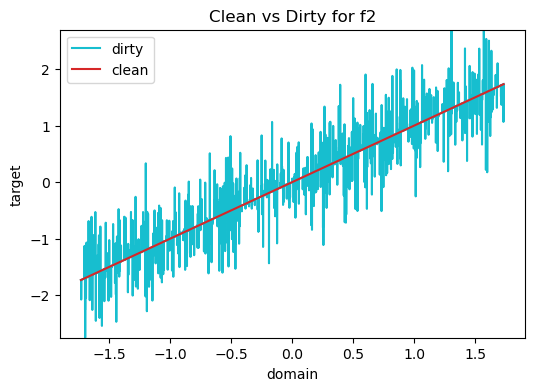

In [6]:
display_function(domain.copy(), offset, 2, 'Clean vs Dirty for f2')

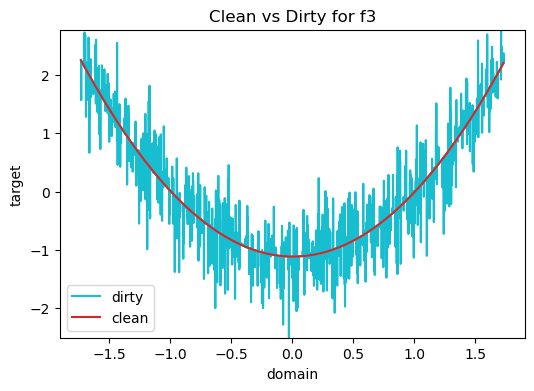

In [7]:
display_function(domain.copy(), offset, 3, 'Clean vs Dirty for f3')

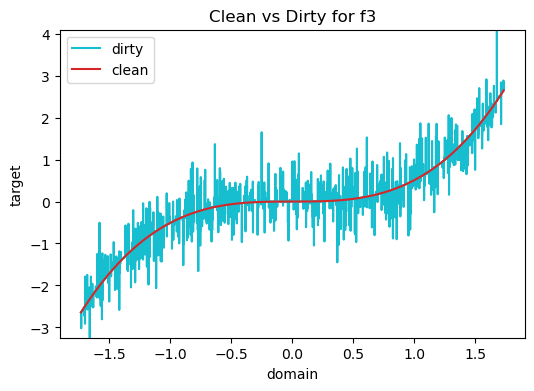

In [8]:
display_function(domain.copy(), offset, 4, 'Clean vs Dirty for f3')  

# Data Preprocessing

### Splitting into train and val

In [9]:
from sklearn.model_selection import train_test_split

X_train_clean, X_val_clean, y_train_clean, y_val_clean = train_test_split(X_clean, y_clean, test_size=2/7)
X_train_dirty, X_val_dirty, y_train_dirty, y_val_dirty = train_test_split(X_dirty, y_dirty, test_size=2/7)

### Creating Dataset

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader

In [11]:
class CustomDataset(Dataset):
    def __init__(self, X, y, mode):
        super(CustomDataset, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
        
        self.dim = self.X.shape[0]
        print('Finished reading the {} set of Dataset ({} samples found, each dim = {})'.format(mode, len(self.X), self.dim))
        print(f"\tX.shape, X.dtype = {self.X.shape}, {self.X.dtype}")
        print(f"\ty.shape, y.dtype = {self.y.shape}, {self.y.dtype}")


    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [12]:
trainset_clean = CustomDataset(X_train_clean, y_train_clean, mode='train')
valset_clean = CustomDataset(X_val_clean, y_val_clean, mode='val')
trainset_dirty = CustomDataset(X_train_dirty, y_train_dirty, mode='train')
valset_dirty = CustomDataset(X_val_dirty, y_val_dirty, mode='val')

Finished reading the train set of Dataset (5000 samples found, each dim = 5000)
	X.shape, X.dtype = torch.Size([5000, 10]), torch.float32
	y.shape, y.dtype = torch.Size([5000, 1]), torch.float32
Finished reading the val set of Dataset (2000 samples found, each dim = 2000)
	X.shape, X.dtype = torch.Size([2000, 10]), torch.float32
	y.shape, y.dtype = torch.Size([2000, 1]), torch.float32
Finished reading the train set of Dataset (5000 samples found, each dim = 5000)
	X.shape, X.dtype = torch.Size([5000, 10]), torch.float32
	y.shape, y.dtype = torch.Size([5000, 1]), torch.float32
Finished reading the val set of Dataset (2000 samples found, each dim = 2000)
	X.shape, X.dtype = torch.Size([2000, 10]), torch.float32
	y.shape, y.dtype = torch.Size([2000, 1]), torch.float32


### Creating Dataloader

In [13]:
train_loader_clean = DataLoader(trainset_clean, batch_size=config['batch_size'], shuffle=True)
val_loader_clean = DataLoader(valset_clean, batch_size=config['batch_size'], shuffle=False)
train_loader_dirty = DataLoader(trainset_dirty, batch_size=config['batch_size'], shuffle=True)
val_loader_dirty = DataLoader(valset_dirty, batch_size=config['batch_size'], shuffle=False)

# Defining the Model

In [14]:
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
display(device)

device(type='cuda')

In [15]:
# TODO: Tune this model architecture
class Net(nn.Module):
    def __init__(self, activation_function, d_in=config['num_cols'], d_out=1):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 128),
            nn.BatchNorm1d(128),
            activation_function(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            activation_function(),
            nn.Linear(64, d_out),
        )

        self.criterion = nn.MSELoss()
        
    def forward(self, x):
        return self.net(x)

    def cal_loss(self, pred, target):
        return self.criterion(pred, target)

# Training

In [16]:
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from copy import deepcopy

# Testing
from sklearn.metrics import accuracy_score

In [17]:
def train(model, train_loader, val_loader, valset, optimizer=None):
    best_val_loss = 10000
    best_val_model = None
    loss_record = {'train': [], 'val': []}
    if optimizer is None:
        optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    for epoch in range(config['max_epochs']):
        running_loss = 0.0
        running_size = 0
        # this shows a progress bar during training, which is valuable due to how long it takes to train
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = model.cal_loss(outputs, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_size += data.size(0)
            loss_record['train'].append(running_loss/running_size)
        
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for data, target in val_loader:
                out = model(data.to(device)).cpu()
                val_loss += model.cal_loss(out, target).item()

        # this fixes the problem where val_set is off by one during plotting
        loss_record['val'].append(val_loss/len(valset))
        # Just print out the validation accuracy because it doesn't get updated repeatedly like how training accuracy does
        if val_loss/len(valset) < best_val_loss:
            best_val_loss = val_loss / len(valset)
            best_val_model = deepcopy(model.state_dict())
            print("Epoch {0:>2}: train loss={1:<10f} | val loss={2:<10f}".format(epoch+1, running_loss/running_size, val_loss/len(valset)))
    print('Finished Training')
    return loss_record, best_val_model

In [18]:
relu_loss_record_clean, relu_best_model_clean = train(Net(nn.ReLU).to(device), train_loader_clean, val_loader_clean, valset_clean)

Epoch  1: train loss=0.000905   | val loss=0.000562  
Epoch  2: train loss=0.000589   | val loss=0.000527  
Epoch  3: train loss=0.000539   | val loss=0.000514  
Epoch  4: train loss=0.000503   | val loss=0.000478  
Epoch  5: train loss=0.000473   | val loss=0.000466  
Epoch  6: train loss=0.000470   | val loss=0.000457  
Epoch  9: train loss=0.000423   | val loss=0.000448  
Epoch 10: train loss=0.000427   | val loss=0.000448  
Epoch 13: train loss=0.000406   | val loss=0.000436  
Epoch 15: train loss=0.000392   | val loss=0.000429  
Finished Training


In [19]:
relu_loss_record_dirty, relu_best_model_dirty = train(Net(nn.ReLU).to(device), train_loader_dirty, val_loader_dirty, valset_dirty)

Epoch  1: train loss=0.001875   | val loss=0.001115  
Epoch  2: train loss=0.001060   | val loss=0.001007  
Epoch  7: train loss=0.000896   | val loss=0.000994  
Epoch  9: train loss=0.000862   | val loss=0.000960  
Epoch 12: train loss=0.000825   | val loss=0.000932  
Finished Training


In [20]:
lrelu_loss_record_clean, lrelu_best_model_clean = train(Net(nn.LeakyReLU).to(device), train_loader_clean, val_loader_clean, valset_clean)

Epoch  1: train loss=0.001256   | val loss=0.000602  
Epoch  2: train loss=0.000634   | val loss=0.000567  
Epoch  3: train loss=0.000549   | val loss=0.000497  
Epoch  4: train loss=0.000528   | val loss=0.000489  
Epoch  7: train loss=0.000474   | val loss=0.000470  
Epoch  9: train loss=0.000433   | val loss=0.000450  
Epoch 12: train loss=0.000416   | val loss=0.000446  
Epoch 15: train loss=0.000413   | val loss=0.000430  
Epoch 16: train loss=0.000414   | val loss=0.000430  
Epoch 19: train loss=0.000362   | val loss=0.000420  
Finished Training


In [21]:
lrelu_loss_record_dirty, lrelu_best_model_dirty = train(Net(nn.LeakyReLU).to(device), train_loader_dirty, val_loader_dirty, valset_dirty)

Epoch  1: train loss=0.001324   | val loss=0.001081  
Epoch  2: train loss=0.001053   | val loss=0.000985  
Epoch  3: train loss=0.000997   | val loss=0.000957  
Epoch  4: train loss=0.000948   | val loss=0.000934  
Epoch  5: train loss=0.000932   | val loss=0.000926  
Epoch  7: train loss=0.000872   | val loss=0.000916  
Epoch  9: train loss=0.000870   | val loss=0.000906  
Finished Training


In [22]:
prelu_loss_record_clean, prelu_best_model_clean = train(Net(nn.PReLU).to(device), train_loader_clean, val_loader_clean, valset_clean)

Epoch  1: train loss=0.000848   | val loss=0.000593  
Epoch  2: train loss=0.000586   | val loss=0.000508  
Epoch  3: train loss=0.000573   | val loss=0.000493  
Epoch  4: train loss=0.000540   | val loss=0.000478  
Epoch  7: train loss=0.000499   | val loss=0.000463  
Epoch  9: train loss=0.000482   | val loss=0.000460  
Epoch 11: train loss=0.000482   | val loss=0.000457  
Epoch 13: train loss=0.000462   | val loss=0.000449  
Epoch 15: train loss=0.000459   | val loss=0.000447  
Finished Training


In [23]:
prelu_loss_record_dirty, prelu_best_model_dirty = train(Net(nn.PReLU).to(device), train_loader_dirty, val_loader_dirty, valset_dirty)

Epoch  1: train loss=0.001385   | val loss=0.001004  
Epoch  3: train loss=0.001037   | val loss=0.000939  
Epoch  4: train loss=0.001003   | val loss=0.000924  
Epoch  6: train loss=0.000955   | val loss=0.000899  
Epoch 10: train loss=0.000903   | val loss=0.000894  
Epoch 15: train loss=0.000858   | val loss=0.000880  
Finished Training


In [24]:
elu_loss_record_clean, elu_best_model_clean = train(Net(nn.ELU).to(device), train_loader_clean, val_loader_clean, valset_clean)

Epoch  1: train loss=0.000845   | val loss=0.000567  
Epoch  2: train loss=0.000597   | val loss=0.000527  
Epoch  3: train loss=0.000578   | val loss=0.000506  
Epoch  4: train loss=0.000556   | val loss=0.000505  
Epoch  5: train loss=0.000556   | val loss=0.000496  
Epoch  6: train loss=0.000537   | val loss=0.000477  
Epoch  8: train loss=0.000518   | val loss=0.000465  
Epoch  9: train loss=0.000506   | val loss=0.000459  
Epoch 10: train loss=0.000532   | val loss=0.000456  
Epoch 14: train loss=0.000492   | val loss=0.000453  
Epoch 17: train loss=0.000488   | val loss=0.000452  
Epoch 18: train loss=0.000481   | val loss=0.000447  
Epoch 19: train loss=0.000471   | val loss=0.000442  
Epoch 20: train loss=0.000478   | val loss=0.000434  
Finished Training


In [25]:
elu_loss_record_dirty, elu_best_model_dirty = train(Net(nn.ELU).to(device), train_loader_dirty, val_loader_dirty, valset_dirty)

Epoch  1: train loss=0.001513   | val loss=0.001008  
Epoch  2: train loss=0.001101   | val loss=0.001006  
Epoch  3: train loss=0.001108   | val loss=0.000944  
Epoch  4: train loss=0.001034   | val loss=0.000933  
Epoch  7: train loss=0.000976   | val loss=0.000911  
Epoch 10: train loss=0.000940   | val loss=0.000901  
Epoch 13: train loss=0.000958   | val loss=0.000898  
Finished Training


In [26]:
softsign_loss_record_clean, softsign_best_model_clean = train(Net(nn.Softsign).to(device), train_loader_clean, val_loader_clean, valset_clean)

Epoch  1: train loss=0.000800   | val loss=0.000697  
Epoch  2: train loss=0.000694   | val loss=0.000686  
Epoch  3: train loss=0.000682   | val loss=0.000658  
Epoch  4: train loss=0.000639   | val loss=0.000653  
Epoch  5: train loss=0.000629   | val loss=0.000633  
Epoch  6: train loss=0.000612   | val loss=0.000618  
Epoch  7: train loss=0.000598   | val loss=0.000604  
Epoch  8: train loss=0.000570   | val loss=0.000568  
Epoch  9: train loss=0.000563   | val loss=0.000562  
Epoch 10: train loss=0.000492   | val loss=0.000529  
Epoch 12: train loss=0.000488   | val loss=0.000506  
Epoch 13: train loss=0.000482   | val loss=0.000495  
Epoch 14: train loss=0.000460   | val loss=0.000482  
Epoch 19: train loss=0.000444   | val loss=0.000477  
Epoch 20: train loss=0.000435   | val loss=0.000470  
Finished Training


In [27]:
softsign_loss_record_dirty, softsign_best_model_dirty = train(Net(nn.Softsign).to(device), train_loader_dirty, val_loader_dirty, valset_dirty)

Epoch  1: train loss=0.001264   | val loss=0.001120  
Epoch  2: train loss=0.001136   | val loss=0.001091  
Epoch  3: train loss=0.001109   | val loss=0.001077  
Epoch  5: train loss=0.001060   | val loss=0.001063  
Epoch  7: train loss=0.001022   | val loss=0.001060  
Epoch  9: train loss=0.000993   | val loss=0.001038  
Epoch 10: train loss=0.001022   | val loss=0.001029  
Epoch 11: train loss=0.000963   | val loss=0.000989  
Epoch 12: train loss=0.000932   | val loss=0.000984  
Epoch 13: train loss=0.000948   | val loss=0.000976  
Epoch 16: train loss=0.000900   | val loss=0.000948  
Epoch 18: train loss=0.000856   | val loss=0.000946  
Epoch 19: train loss=0.000886   | val loss=0.000935  
Epoch 20: train loss=0.000847   | val loss=0.000917  
Finished Training


In [28]:
sigmoid_loss_record_clean, sigmoid_best_model_clean = train(Net(nn.Sigmoid).to(device), train_loader_clean, val_loader_clean, valset_clean)

Epoch  1: train loss=0.000716   | val loss=0.000614  
Epoch  9: train loss=0.000624   | val loss=0.000573  
Epoch 10: train loss=0.000600   | val loss=0.000571  
Epoch 12: train loss=0.000563   | val loss=0.000479  
Epoch 13: train loss=0.000533   | val loss=0.000464  
Epoch 16: train loss=0.000509   | val loss=0.000459  
Epoch 18: train loss=0.000490   | val loss=0.000446  
Epoch 20: train loss=0.000487   | val loss=0.000442  
Finished Training


In [29]:
sigmoid_loss_record_dirty, sigmoid_best_model_dirty = train(Net(nn.Sigmoid).to(device), train_loader_dirty, val_loader_dirty, valset_dirty)

Epoch  1: train loss=0.001227   | val loss=0.001047  
Epoch  4: train loss=0.001114   | val loss=0.001043  
Epoch  5: train loss=0.001088   | val loss=0.001032  
Epoch  7: train loss=0.001087   | val loss=0.001021  
Epoch 10: train loss=0.001087   | val loss=0.001000  
Epoch 11: train loss=0.001043   | val loss=0.000973  
Epoch 13: train loss=0.000999   | val loss=0.000956  
Epoch 14: train loss=0.000991   | val loss=0.000937  
Epoch 16: train loss=0.000973   | val loss=0.000900  
Finished Training


In [30]:
tanh_loss_record_clean, tanh_best_model_clean = train(Net(nn.Tanh).to(device), train_loader_clean, val_loader_clean, valset_clean)

Epoch  1: train loss=0.001008   | val loss=0.000730  
Epoch  2: train loss=0.000723   | val loss=0.000673  
Epoch  3: train loss=0.000678   | val loss=0.000667  
Epoch  5: train loss=0.000639   | val loss=0.000638  
Epoch  7: train loss=0.000606   | val loss=0.000561  
Epoch  8: train loss=0.000563   | val loss=0.000548  
Epoch  9: train loss=0.000547   | val loss=0.000516  
Epoch 10: train loss=0.000517   | val loss=0.000507  
Epoch 11: train loss=0.000504   | val loss=0.000490  
Epoch 13: train loss=0.000497   | val loss=0.000473  
Epoch 14: train loss=0.000470   | val loss=0.000463  
Epoch 16: train loss=0.000482   | val loss=0.000459  
Epoch 20: train loss=0.000459   | val loss=0.000454  
Finished Training


In [31]:
tanh_loss_record_dirty, tanh_best_model_dirty = train(Net(nn.Tanh).to(device), train_loader_dirty, val_loader_dirty, valset_dirty)

Epoch  1: train loss=0.001395   | val loss=0.001118  
Epoch  2: train loss=0.001152   | val loss=0.001107  
Epoch  4: train loss=0.001098   | val loss=0.001099  
Epoch  5: train loss=0.001070   | val loss=0.001045  
Epoch  8: train loss=0.001032   | val loss=0.001039  
Epoch  9: train loss=0.001001   | val loss=0.001006  
Epoch 11: train loss=0.000966   | val loss=0.000982  
Epoch 12: train loss=0.000951   | val loss=0.000967  
Epoch 13: train loss=0.000938   | val loss=0.000957  
Epoch 17: train loss=0.000912   | val loss=0.000932  
Epoch 19: train loss=0.000875   | val loss=0.000921  
Epoch 20: train loss=0.000871   | val loss=0.000919  
Finished Training


### Plotting Learning Curve

In [32]:
from matplotlib.pyplot import figure

def plot_learning_curve(loss_record, title='', num_std_devs=3):
    ''' Plot learning curve of your DNN (train & val loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    offset = len(loss_record['train']) // len(loss_record['val'])
    x_2 = range(offset, total_steps + offset, offset)
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['val'], c='tab:cyan', label='val')
    
    y_lim_low = min(np.mean(loss_record['train']) - num_std_devs * np.std(loss_record['train']), 
                    np.mean(loss_record['val']) - num_std_devs * np.std(loss_record['val']))
    y_lim_high = max(np.mean(loss_record['train']) + num_std_devs * np.std(loss_record['train']), 
                    np.mean(loss_record['val']) + num_std_devs * np.std(loss_record['val']))
    
    plt.ylim(y_lim_low, y_lim_high)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

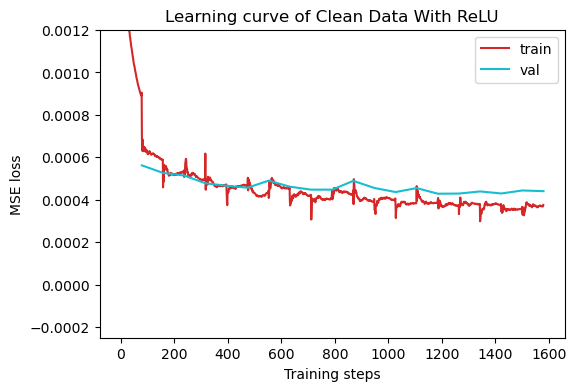

In [33]:
plot_learning_curve(relu_loss_record_clean, title="Clean Data With ReLU")

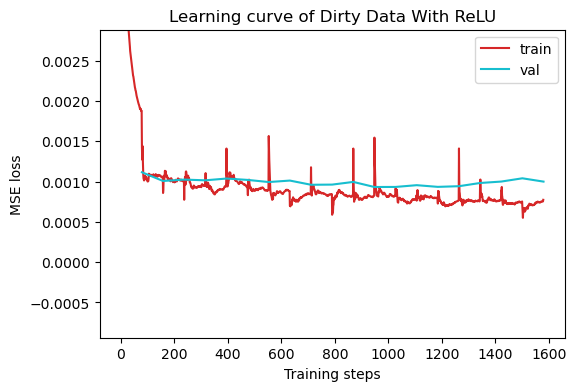

In [34]:
plot_learning_curve(relu_loss_record_dirty, title="Dirty Data With ReLU")

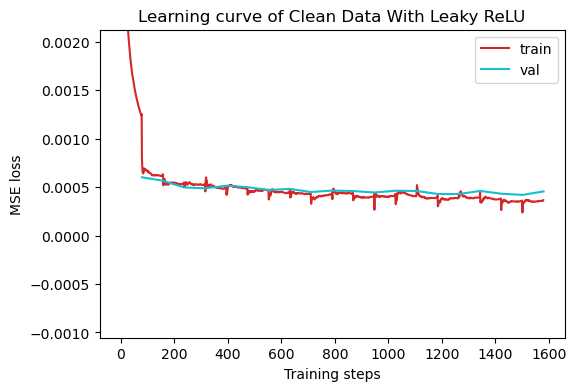

In [35]:
plot_learning_curve(lrelu_loss_record_clean, title="Clean Data With Leaky ReLU")

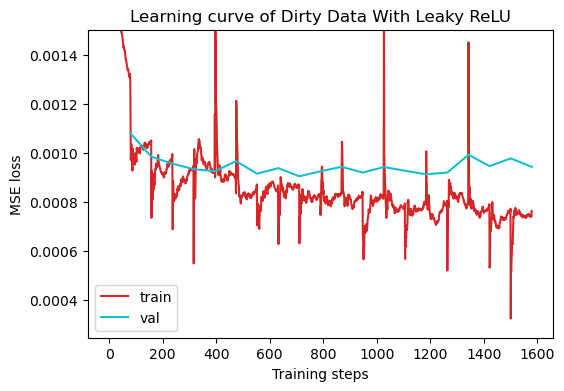

In [36]:
plot_learning_curve(lrelu_loss_record_dirty, title="Dirty Data With Leaky ReLU")

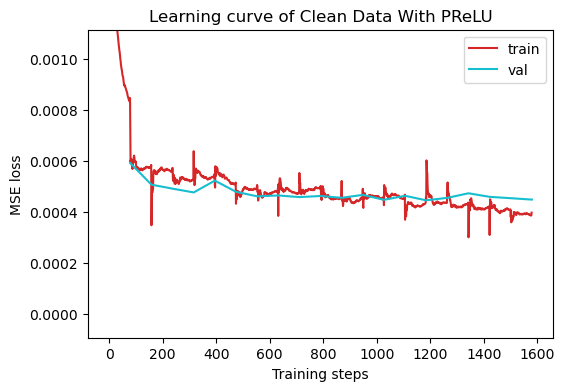

In [37]:
plot_learning_curve(prelu_loss_record_clean, title="Clean Data With PReLU")

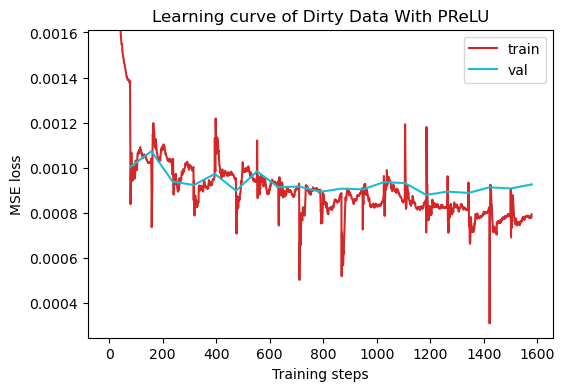

In [38]:
plot_learning_curve(prelu_loss_record_dirty, title="Dirty Data With PReLU")

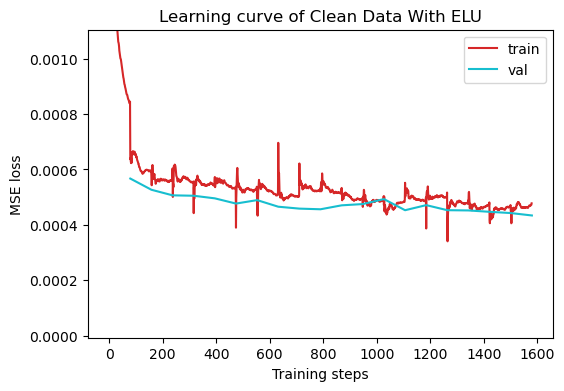

In [39]:
plot_learning_curve(elu_loss_record_clean, title="Clean Data With ELU")

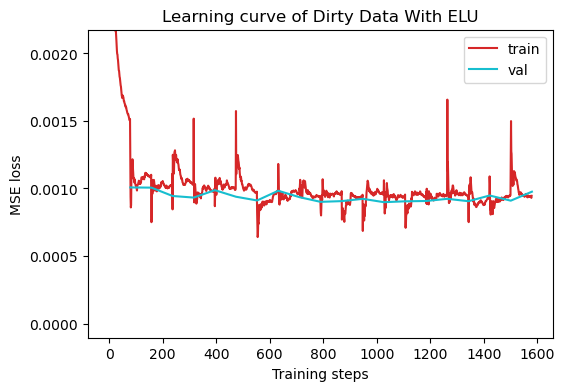

In [40]:
plot_learning_curve(elu_loss_record_dirty, title="Dirty Data With ELU")

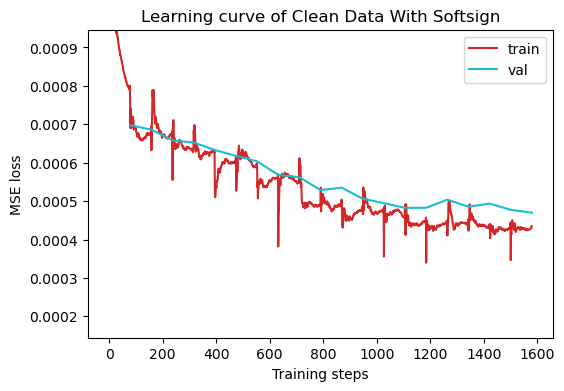

In [41]:
plot_learning_curve(softsign_loss_record_clean, title="Clean Data With Softsign")

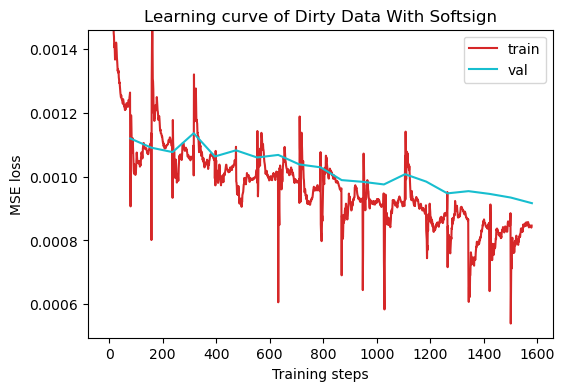

In [42]:
plot_learning_curve(softsign_loss_record_dirty, title="Dirty Data With Softsign")

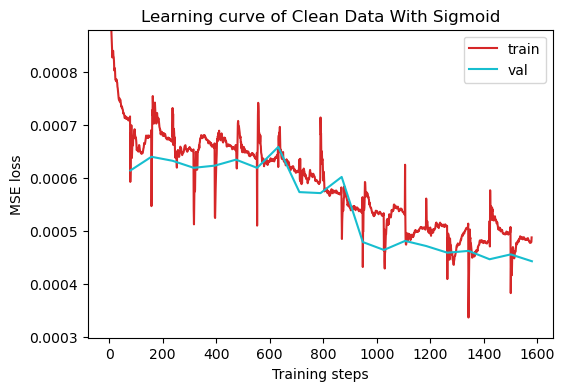

In [43]:
plot_learning_curve(sigmoid_loss_record_clean, title="Clean Data With Sigmoid")

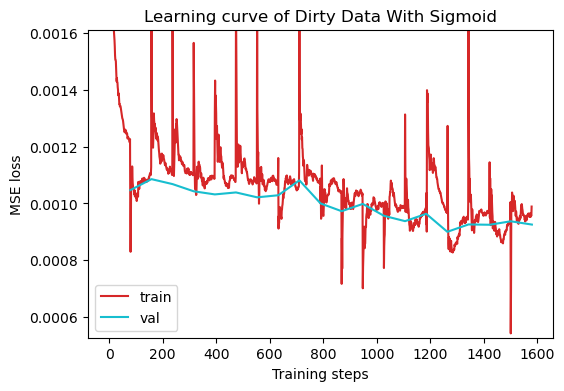

In [44]:
plot_learning_curve(sigmoid_loss_record_dirty, title="Dirty Data With Sigmoid")

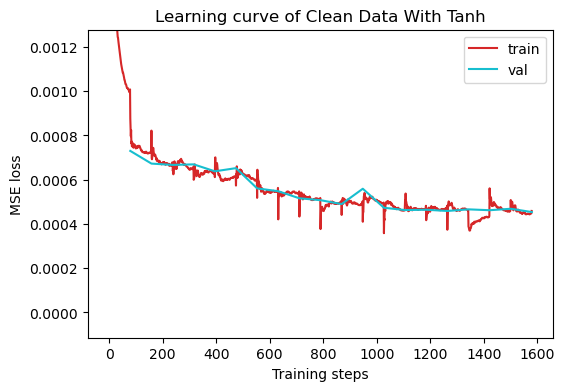

In [45]:
plot_learning_curve(tanh_loss_record_clean, title="Clean Data With Tanh")

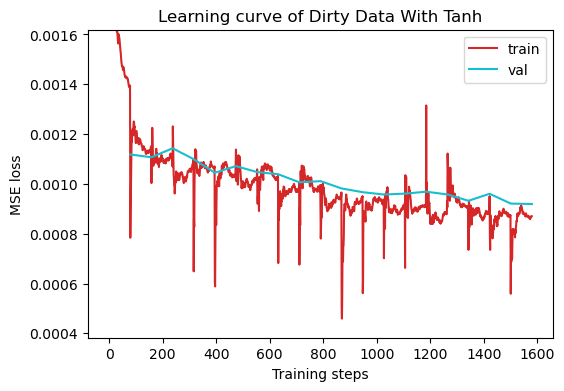

In [46]:
plot_learning_curve(tanh_loss_record_dirty, title="Dirty Data With Tanh")

# Comparing the Models

In [47]:
def plot_vals(dirty, clean, title='', num_std_devs=3):
    plt.plot(range(len(dirty)), dirty, label='dirty')
    plt.plot(range(len(clean)), clean, label='clean')
    # plt.plot(range(len(dirty)), dirty, c='tab:cyan', label='dirty')
    # plt.plot(range(len(clean)), clean, c='tab:red', label='clean')
    y_lim_low = min(np.mean(clean) - num_std_devs * np.std(clean), 
                    np.mean(dirty) - num_std_devs * np.std(dirty))
    y_lim_high = max(np.mean(clean) + num_std_devs * np.std(clean), 
                    np.mean(dirty) + num_std_devs * np.std(dirty))
    plt.ylim(y_lim_low, y_lim_high)
    plt.xlabel('Epochs')
    plt.ylabel('MSE loss')
    plt.title('Val Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

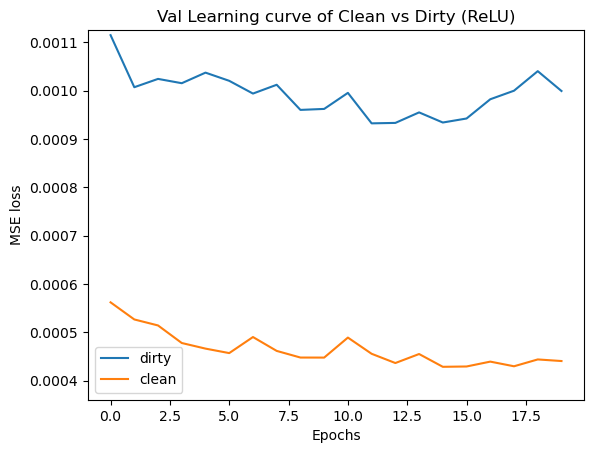

In [48]:
plot_vals(relu_loss_record_dirty['val'], relu_loss_record_clean['val'], title="Clean vs Dirty (ReLU)")

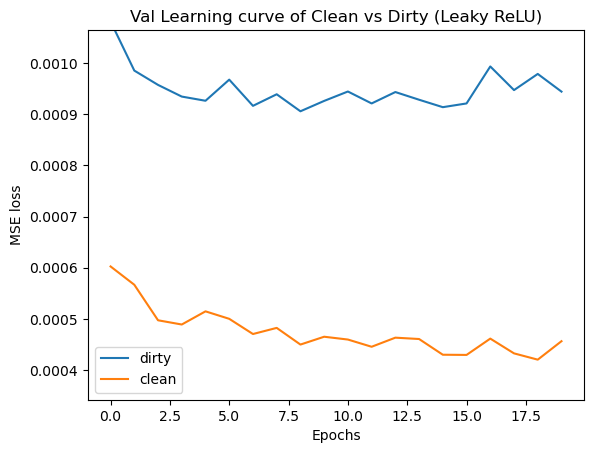

In [49]:
plot_vals(lrelu_loss_record_dirty['val'], lrelu_loss_record_clean['val'], title="Clean vs Dirty (Leaky ReLU)")

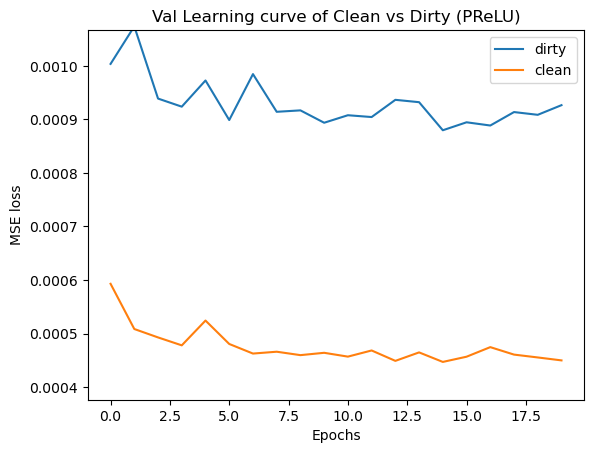

In [50]:
plot_vals(prelu_loss_record_dirty['val'], prelu_loss_record_clean['val'], title="Clean vs Dirty (PReLU)")

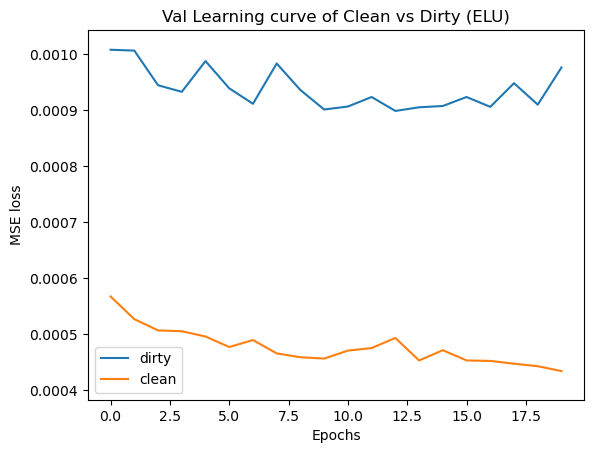

In [51]:
plot_vals(elu_loss_record_dirty['val'], elu_loss_record_clean['val'], title="Clean vs Dirty (ELU)")

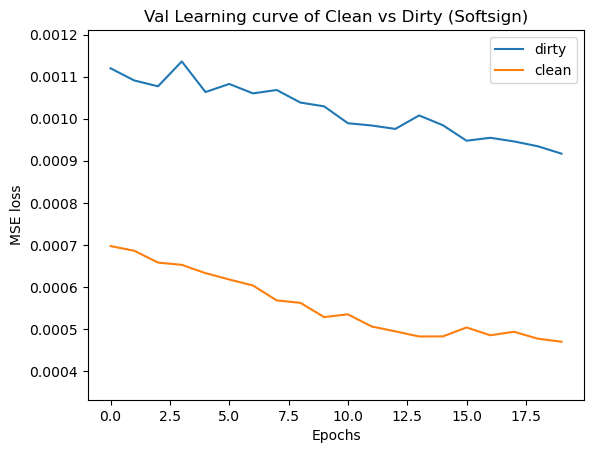

In [52]:
plot_vals(softsign_loss_record_dirty['val'], softsign_loss_record_clean['val'], title="Clean vs Dirty (Softsign)")

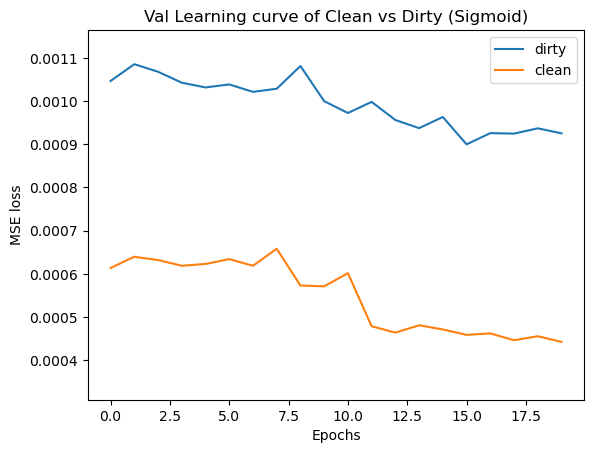

In [53]:
plot_vals(sigmoid_loss_record_dirty['val'], sigmoid_loss_record_clean['val'], title="Clean vs Dirty (Sigmoid)")

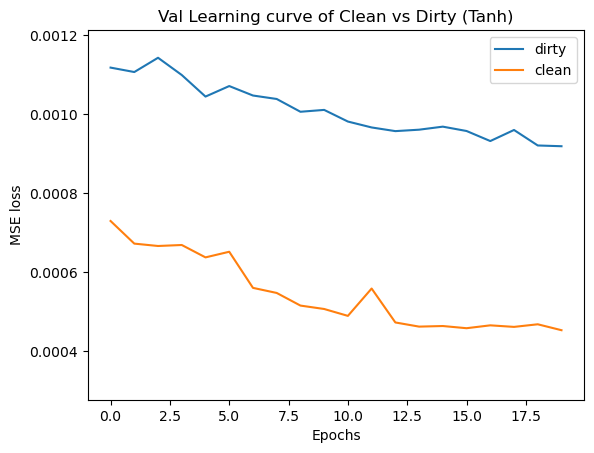

In [54]:
plot_vals(tanh_loss_record_dirty['val'], tanh_loss_record_clean['val'], title="Clean vs Dirty (Tanh)")

### Plotting Differential

In [55]:
def plot_diff(diffs, labels, title='', num_std_devs=3):
    mins = []
    maxs = []
    for i in range(len(diffs)):
        plt.plot(range(len(diffs[i])), diffs[i], label=labels[i])
        mins.append(np.mean(diffs[i]) - num_std_devs * np.std(diffs[i]))
        maxs.append(np.mean(diffs[i]) + num_std_devs * np.std(diffs[i]))
    plt.ylim(min(mins), max(maxs))
    plt.xlabel('Training steps')
    plt.ylabel('Dirty MSE Loss - Clean MSE Loss')
    plt.title(title)
    plt.legend()
    plt.show()

In [56]:
def list_mag_diff(list1, list2):
    answer = []
    for i in range(len(list1)):
        answer.append(abs(list1[i] - list2[i]))
    return answer

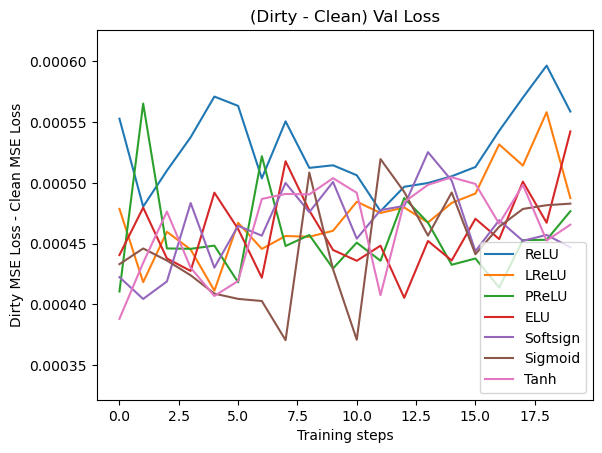

In [57]:
DIFF_relu_lrd = list_mag_diff(relu_loss_record_dirty['val'], relu_loss_record_clean['val'])
DIFF_lrelu_lrd = list_mag_diff(lrelu_loss_record_dirty['val'], lrelu_loss_record_clean['val'])
DIFF_prelu_lrd = list_mag_diff(prelu_loss_record_dirty['val'], prelu_loss_record_clean['val'])
DIFF_elu_lrd = list_mag_diff(elu_loss_record_dirty['val'], elu_loss_record_clean['val'])
DIFF_softsign_lrd = list_mag_diff(softsign_loss_record_dirty['val'], softsign_loss_record_clean['val'])
DIFF_sigmoid_lrd = list_mag_diff(sigmoid_loss_record_dirty['val'], sigmoid_loss_record_clean['val'])
DIFF_tanh_lrd = list_mag_diff(tanh_loss_record_dirty['val'], tanh_loss_record_clean['val'])

plot_diff(
    diffs=[DIFF_relu_lrd, DIFF_lrelu_lrd, DIFF_prelu_lrd, DIFF_elu_lrd, DIFF_softsign_lrd, DIFF_sigmoid_lrd, DIFF_tanh_lrd], 
    labels=['ReLU', 'LReLU', 'PReLU', 'ELU', 'Softsign', 'Sigmoid', 'Tanh'], 
    title='(Dirty - Clean) Val Loss'
)